# Leave-One-Out Cross Validation

Environment: R 3.6.1 and Jupyter notebook

Libraries used:
* dplyr
* ggplot2

## Introduction

In this notebook, a Leave-One-Out Cross Validation need to be implemented on KNN regressor, which is defined in the `knn_regressor.ipynb`, as a function `cv(train.data, train.label, K, numFold=?)`. 

## Import libraries

In [1]:
library(dplyr)
library(ggplot2)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


## Use the code from `knn_regressor.ipynb`

In [2]:
read_data <- function(fname, sc) {
  data <- read.csv(file = fname, head = TRUE, sep = ",")
  nr = dim(data)[1]
  nc = dim(data)[2]
  x = data[1:nr, 1:(nc - 1)]
  y = data[1:nr, nc]
  if (isTRUE(sc)) {
    x = scale(x)
    y = scale(y)
  }
  return(list("x" = x, "y" = y))
}

KNNRegressor <- setRefClass("KNNRegressor",
                            fields = list(k = "numeric", x_train = "data.frame", y_train = "data.frame"),
                            methods = list(
                                
                              initialize = function(k) {
                                .self$k <- k
                              },

                              fit = function(x_train, y_train) {
                                .self$x_train <- x_train
                                .self$y_train <- y_train
                                .self
                              },

                              predict = function(x_test) {
                                # define a inner function `majority`  
                                majority <- function(x) mean(x)
                                # define a inner function for applying each row
                                predict_for_row <- function(x_test_row) {
                                  # calculate the distance for each test data
                                  distance <- .self$x_train %>% 
                                    apply(1, function(x_train_row) {
                                    # Manhattan distance function
                                    x_train_row["dist"] <- sum(abs(x_train_row - x_test_row))
                                    x_train_row
                                    }) %>% 
                                    t %>% 
                                    as.data.frame %>% .["dist"]
                                    
                                  # find the K nearest neighbours' labels
                                  nearest_indexes <- order(distance$dist)[1:k]
                                  train_labels <- .self$y_train[nearest_indexes,]
                                  # predict the test labels with the mean of nearest neighbours
                                  y_pred_row <- majority(train_labels)
                                  y_pred_row
                                }
                                
                                y_pred <- apply(x_test, 1, predict_for_row)
                                y_pred
                              }
                            )
)

knn <- function(train.data, train.label, test.data, K=3) {
  knn_regressor <- KNNRegressor(K)$fit(as.data.frame(train.data), as.data.frame(train.label))
  knn_regressor$predict(as.data.frame(test.data))
}

error_func <- function(test.pred, test.label) {
  mean((test.pred - test.label) ^ 2)
}

## Read data

In [3]:
# read the train and test data
train_data <- read_data("train1.csv", FALSE)
x_train <- train_data$x
y_train <- train_data$y
test_data <- read_data("test1.csv", FALSE)
x_test <- test_data$x
y_test <- test_data$y

# concat the train and test data
x <- c(x_train, x_test)
y <- c(y_train, y_test)

## Implement cross validation

Here is the `cross_validation` function implemented for generic purpose.

The function cross_validation contains 4 arguments,
- `x`: predictors
- `y`: labels
- `num_fold`: the number of folds in cross validation
- `pred_func`: callback function which receive 3 arguments `x_train`, `y_train`, `x_data` to predict `y_pred`
- `error_func`: callback function which receive 2 arguments `y_pred`, `y_label` to calculate the error.

Return: the errors for each fold.

In [4]:
cross_validation <- function(x, y, num_fold, pred_func, error_func) {
  # test data length, which is calculated from num_fold
  test_length <- floor(nrow(x) / num_fold)
  # A function for split the x, y dataset to `num_fold` parts
  divide_data <- function(i) {
    index <- i:(i + test_length - 1)
    list(x=x[index,], y=y[index])
  }
  I <- 1 + (0:(num_fold-1)) * test_length
  data_blocks <- lapply(I, divide_data)
  # calculate error based on the train and test data splitted.  
  calulate_error <- function(i) {
    x_test <- data_blocks[[i]]$x
    y_test <- data_blocks[[i]]$y
    train_blocks <- data_blocks[-i]
    x_train_blocks <- lapply(train_blocks, function(each) each$x)
    y_train_blocks <- lapply(train_blocks, function(each) each$y)
    x_train <- Reduce(rbind, x_train_blocks)
    y_train <- data.frame(unlist(y_train_blocks))
    y_pred <- pred_func(x_train, y_train, x_test)
    error_func(y_pred, y_test)
  }
  # calculate errors for all fold                            
  sapply(1:num_fold, calulate_error)
}

This function is to apply the Leave-One-Out Cross Validation, which is special condition when `num_fold` is the length of dataset.

In [5]:
cv <- function(train.data, train.label, K, numFold=nrow(train.data)) {
  pred_func <- function(x_train, y_train, x_test) knn(x_train, y_train, x_test, K)
  cross_validation(train.data, train.label, numFold, pred_func, error_func)
}

## Visualization

The error of the Leave-One-Out Cross Validation on KNN regressor with K = 1 to 15 need to be visualized.

Define a function `cv_for_k` for easy calculating mean of errors from k

In [6]:
cv_for_k <- function(k) cv(data.frame(x), y, k) %>% mean

In [7]:
# Apply the function to `1:15` to calculate the needed errors.
error <- sapply(1:15, cv_for_k)
error_data <- data.frame(error=error, k=1:15) %>% mutate(x = 1/k)

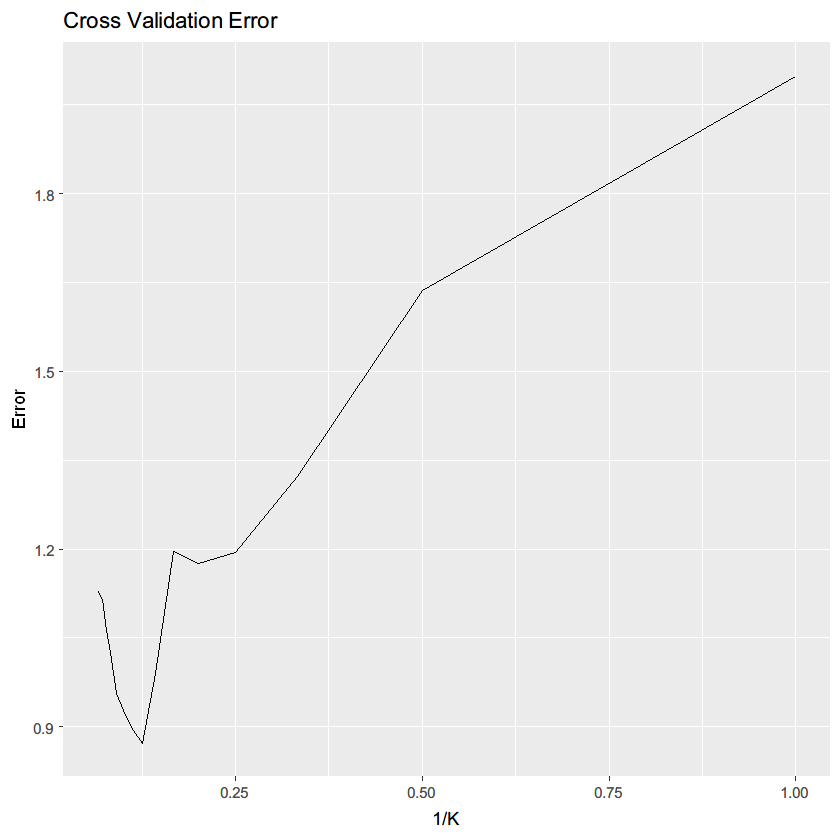

In [8]:
# plot
ggplot(error_data, mapping = aes(x=x, y=error)) + geom_line() + 
  ggtitle('Cross Validation Error') + 
  labs(x="1/K", y="Error")

In [9]:
which.min(error)

[1] 8

## Optimum value

From the visualization and the calculation, it is clearly the model is the best when K = 8.